In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import emcee
import os

import sys
sys.path.insert(0, '../')

In [29]:
k2_time, k2_flux, k2_err = np.loadtxt('../libra/data/trappist_rotation.txt', unpack=True)
k2_flux /= np.percentile(k2_flux, 95)
k2_time_original, k2_flux_original = k2_time.copy(), k2_flux.copy()

In [30]:
# slice in time
condition = (k2_time > 2457773) & (k2_time < 2457779)
k2_time, k2_flux, k2_err= k2_time[condition], k2_flux[condition], k2_err[condition]

<Container object of 3 artists>

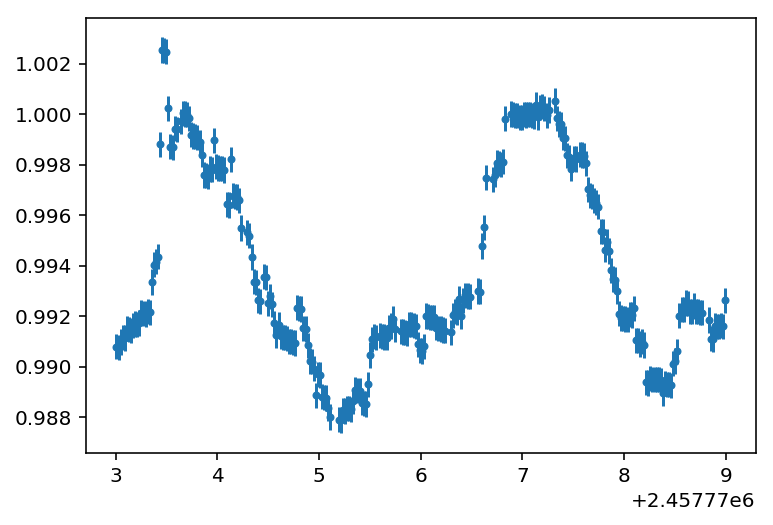

In [4]:
plt.errorbar(k2_time, k2_flux, k2_err, fmt='.')

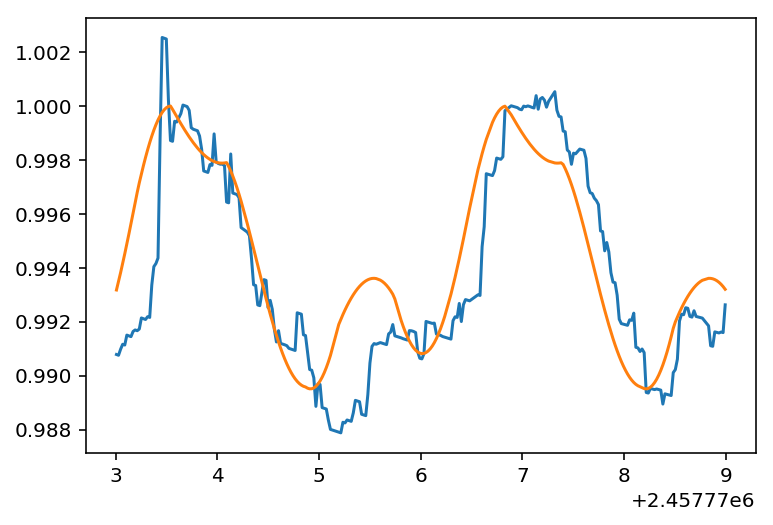

In [5]:
from libra import Spot, Star


spots = [Spot.from_latlon(0, 100, 0.18), 
         Spot.from_latlon(0, 220, 0.17), 
         Spot.from_latlon(0, 5, 0.1)]

star = Star(spots=spots, rotation_period=3.3*u.day)
model_flux =  star.flux(k2_time)
model_flux /= np.max(model_flux)

plt.plot(k2_time, k2_flux)
plt.plot(k2_time, model_flux)


In [6]:
def model(p, time):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, contrast = p
    
    spots = [Spot.from_latlon(lat0, lon0, rad0), 
             Spot.from_latlon(lat1, lon1, rad1), 
             Spot.from_latlon(lat2, lon2, rad2)]

    star = Star(spots=spots, rotation_period=3.3*u.day, contrast=contrast)
    model_flux = star.flux(time)
    model_flux /= np.max(model_flux)

    return model_flux.value

def chi2(p, time):
    return np.sum((model(p, time) - k2_flux)**2 / k2_err**2)

from scipy.optimize import fmin_l_bfgs_b, fmin_powell

initp = np.array([  0.00000000e+00,   1.92817562e+02,   1.45795979e-01,
                    0.00000000e+00,   2.76810097e+02,   1.43055223e-01,
                    0.00000000e+00,   9.58564745e+01,   1.38107241e-01, 
                    0.7])
bounds = [[-90, 90], [0, 360], [0, 1],
          [-90, 90], [0, 360], [0, 1],
          [-90, 90], [0, 360], [0, 1]]

#result0 = fmin_l_bfgs_b(chi2, initp, args=(k2_time, ), approx_grad=True, bounds=bounds)[0]
#result1 = fmin_powell(chi2, initp, args=(k2_time, ))

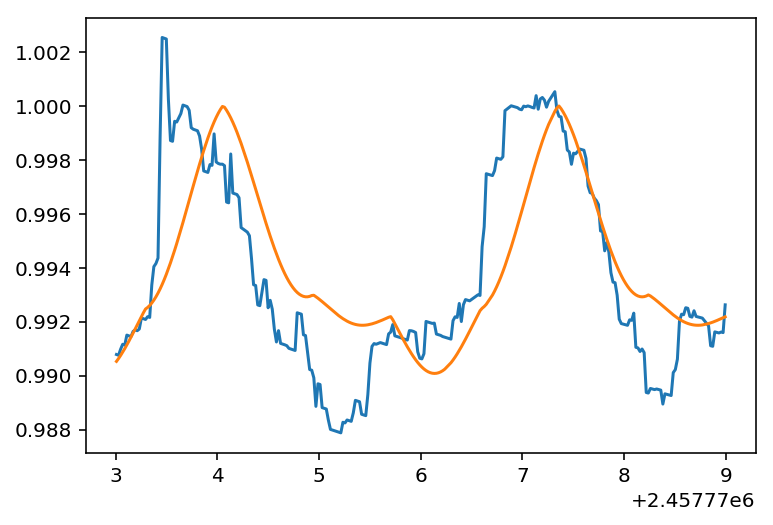

In [7]:
#%matplotlib notebook
plt.plot(k2_time, k2_flux)
plt.plot(k2_time, model(initp, k2_time))
#plt.plot(k2_time, model(result1, k2_time))

In [67]:
def lnprior(p):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, contrast = p
    lats = np.array([lat0, lat1, lat2])
    lons = np.array([lon0, lon1, lon2])
    rads = np.array([rad0, rad1, rad2])
    
    if np.any(lats < -90) or np.any(lats > 90):
        return -np.inf
    if np.any(lons < 0) or np.any(lons > 360):
        return -np.inf
    if np.any(rads < 0) or np.any(rads > 1):
        return -np.inf
    
    if 0 < contrast < 1:
        return 0
    return -np.inf

def lnprob(p, time):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + -0.5*chi2(p, time)

ndim, nwalkers = 10, 40
pos = [initp + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [68]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(k2_time, ), 
                                threads=4)
sampler.run_mcmc(pos, 1000);

In [78]:
n_burnin = 300
old_shape = sampler.chain.shape
new_shape = (old_shape[0] * n_burnin, ndim)
samples = sampler.chain[:, -n_burnin:, :].reshape(new_shape)

In [79]:
labels = ['lat', 'lon', 'rad', 'lat', 'lon', 'rad', 'lat', 'lon', 'rad', 'contrast']

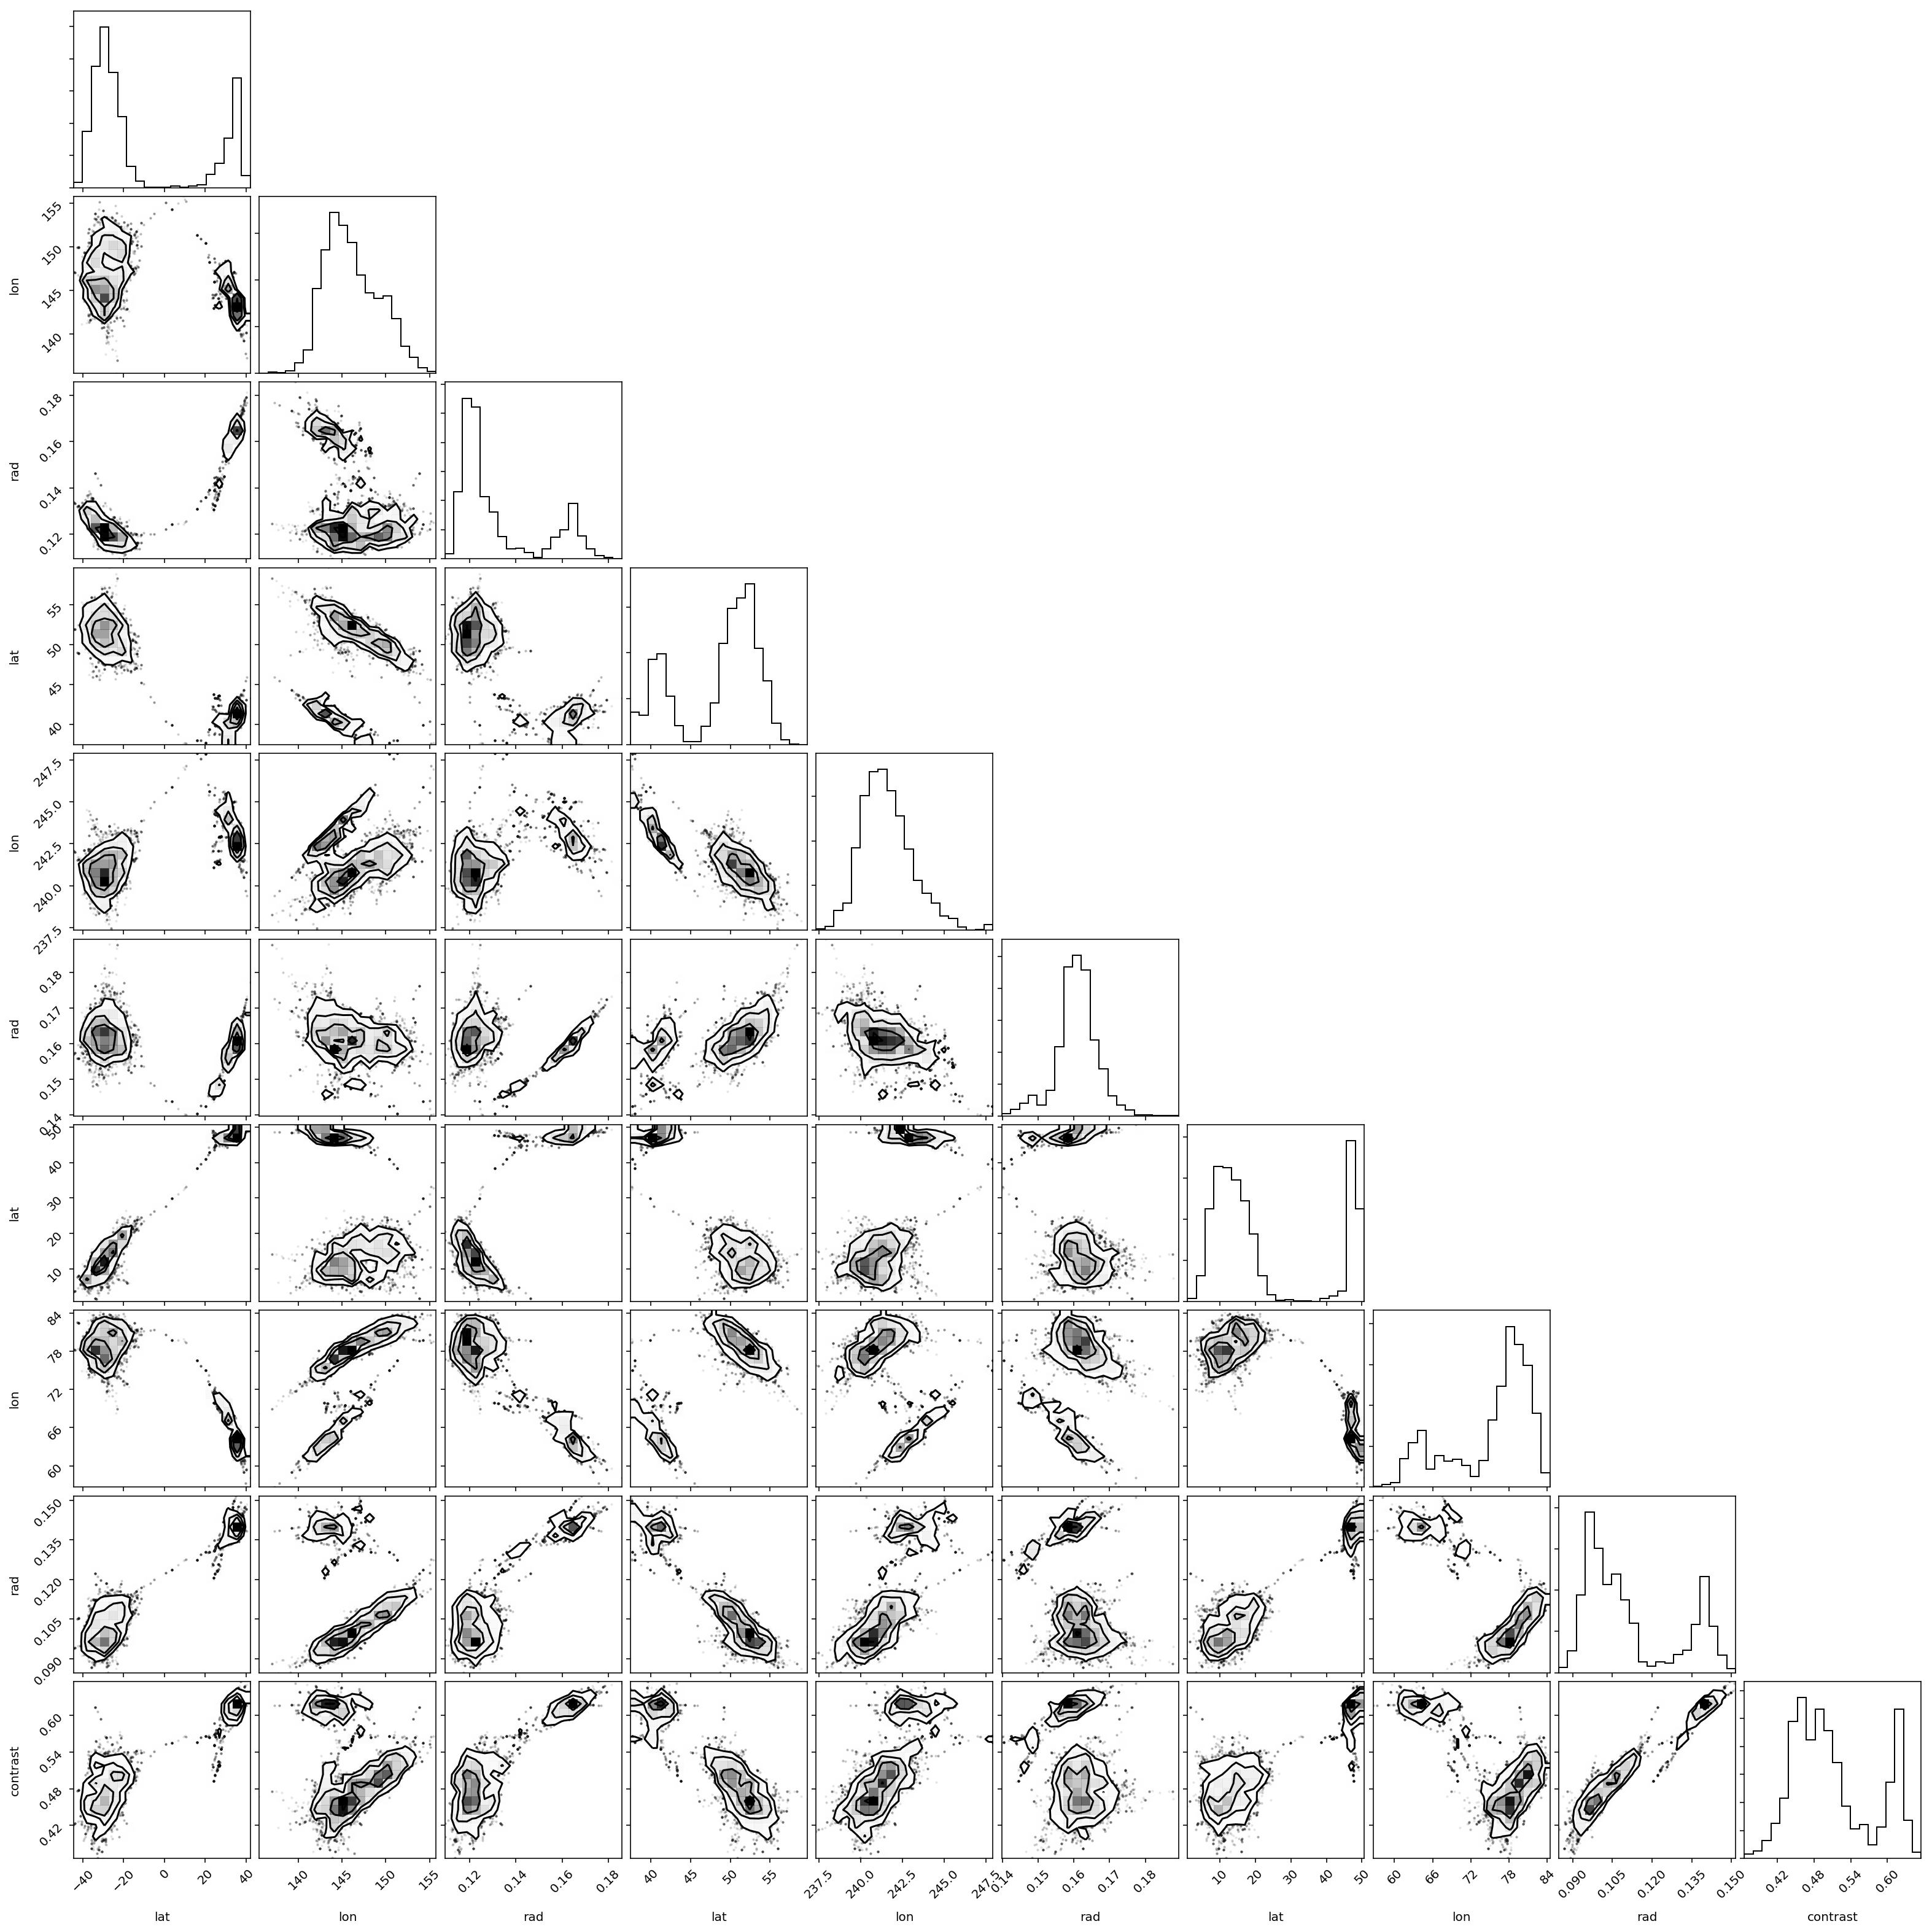

In [80]:
from corner import corner

corner(samples, labels=labels)

plt.savefig('corner.png', bbox_inches='tight', dpi=250)
plt.show()

Text(0.5,0,'contrasts')

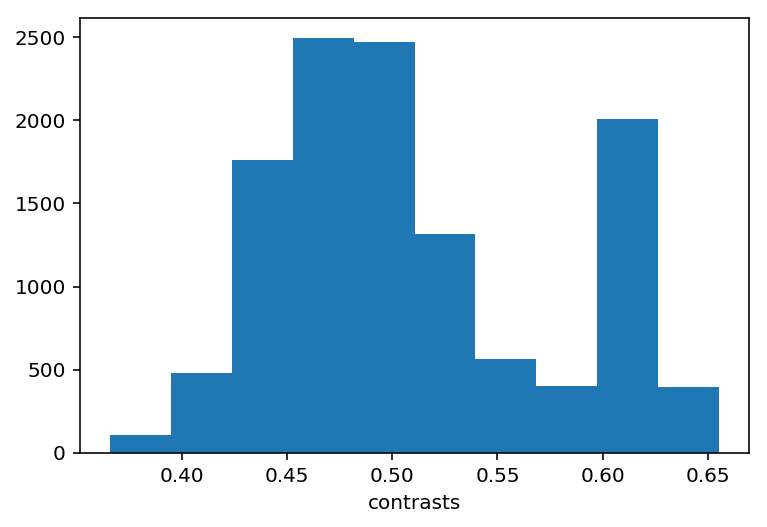

In [81]:
plt.hist(samples[:, -1])
plt.xlabel('contrasts')

Text(0.5,0,'radii')

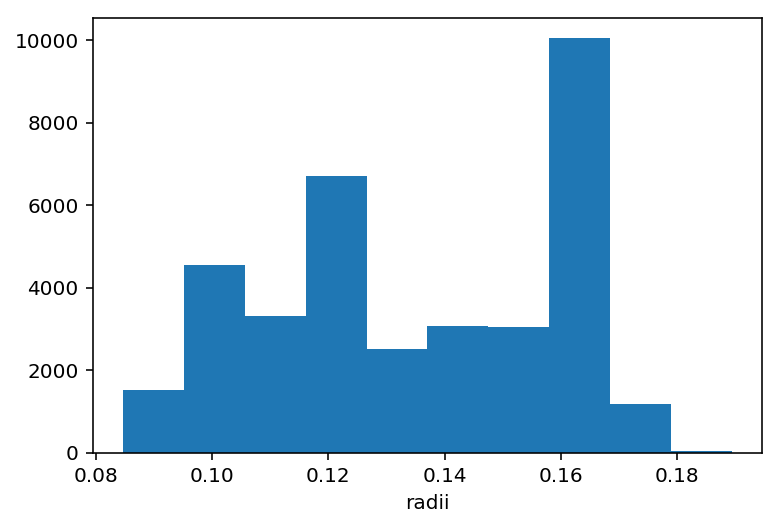

In [82]:
plt.hist(samples[:, 2::3].ravel())
plt.xlabel('radii')

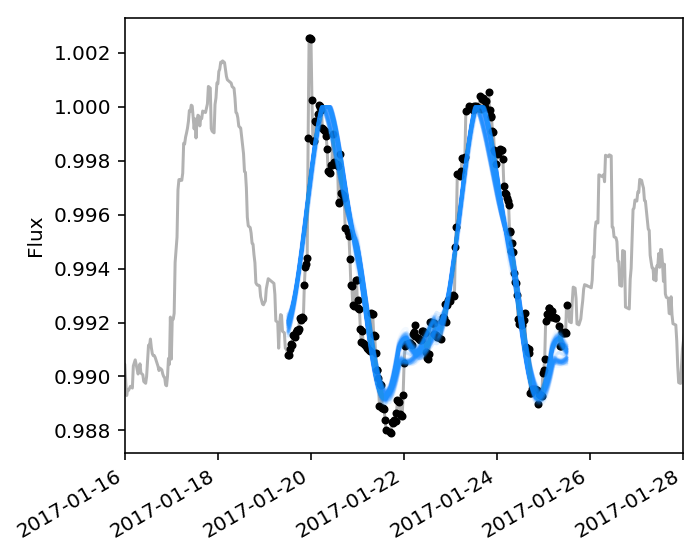

In [83]:
from astropy.time import Time

plt.figure(figsize=(5, 4))
plt.plot_date(Time(k2_time_original, format='jd').plot_date, 
              k2_flux_original, ms=0, ls='-', alpha=0.6, color='gray')

plt.plot_date(Time(k2_time, format='jd').plot_date, k2_flux, '.k', lw=2)

for i in np.random.randint(0, samples.shape[0], 200):
    plt.plot_date(Time(k2_time, format='jd').plot_date, 
                  model(samples[i, :], k2_time), ms=0, ls='-', alpha=0.05, color='DodgerBlue')

ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.ylabel('Flux')
plt.xlim([Time('2017-01-16').plot_date, Time('2017-01-28').plot_date])
plt.savefig('STSP_trappist1.pdf', bbox_inches='tight')
plt.show()